# Influence functions for outlier detection

This notebook shows how to calculate influences on a NN model using pyDVL for an arbitrary dataset, and how this can be used to find anomalous or corrupted data points.

It uses the wine dataset from sklearn: given a set of 13 different input parameters regarding a particular bottle, each related to some physical property (e.g. concentration of magnesium, malic acidity, alcoholic percentage, etc.), the model will need to predict to which of 3 classes the wine belongs to. For more details, please refer to the [sklearn documentation](https://scikit-learn.org/stable/datasets/toy_dataset.html#wine-recognition-dataset).

<div class="alert alert-info">

If you are reading this in the documentation, some boilerplate has been omitted for convenience.

</div>

Let's start by loading the imports, the dataset and splitting it into train, validation and test sets. We will use a large test set to have a less noisy estimate of the average influence.

## Imports

In [1]:
%load_ext autoreload

In [2]:
%autoreload
%matplotlib inline

import os
import random

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from support.common import plot_losses
from support.torch import TorchMLP, fit_torch_model
from pydvl.influence import compute_influences
from pydvl.influence.torch import TorchTwiceDifferentiable
from support.shapley import load_wine_dataset
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score
from torch.optim import Adam, lr_scheduler
from torch.utils.data import DataLoader, TensorDataset
from scipy.stats import pearsonr, spearmanr

/Users/fabio/miniconda3/envs/pydvl_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
plt.rcParams["figure.figsize"] = (16, 8)
plt.rcParams["font.size"] = 12
plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 10
plt.rcParams["axes.facecolor"] = (1, 1, 1, 0)
plt.rcParams["figure.facecolor"] = (1, 1, 1, 0)

## Constants

In [4]:
random_state = 24
is_CI = os.environ.get("CI")

In [5]:
random.seed(random_state)
np.random.seed(random_state)

## Dataset

In [6]:
training_data, val_data, test_data, feature_names = load_wine_dataset(
    train_size=0.6, test_size=0.3
)
# In CI we only use a subset of the training set
if is_CI:
    train_data = (training_data[0][:10], training_data[1][:10])

We will corrupt some of the training points by flipping their labels

In [7]:
num_corrupted_idxs = 10
training_data[1][:num_corrupted_idxs] = torch.tensor(
    [(val + 1) % 3 for val in training_data[1][:num_corrupted_idxs]]
)

and let's wrap it in a pytorch data loader

In [8]:
training_data_loader = DataLoader(
    TensorDataset(*training_data), batch_size=32, shuffle=False
)
val_data_loader = DataLoader(TensorDataset(*val_data), batch_size=32, shuffle=False)
test_data_loader = DataLoader(TensorDataset(*test_data), batch_size=32, shuffle=False)

## Fit a neural network to the data

We will train a 2-layer neural network. PyDVL has some convenience wrappers to initialize a pytorch NN. If you already have a model loaded and trained, you can skip this section.

In [9]:
feature_dimension = 13
num_classes = 3
network_size = [16, 16]
layers_size = [feature_dimension, *network_size, num_classes]
num_epochs = 300
lr = 0.005
weight_decay = 0.01
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

nn_model = TorchMLP(layers_size)
nn_model.to(device)

optimizer = Adam(params=nn_model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

losses = fit_torch_model(
    model=nn_model,
    training_data=training_data_loader,
    val_data=val_data_loader,
    loss=torch.nn.CrossEntropyLoss(),
    optimizer=optimizer,
    scheduler=scheduler,
    num_epochs=num_epochs,
)

Model fitting:   5%|▍         | 14/300 [00:00<00:06, 43.11it/s]

Model fitting: 100%|██████████| 300/300 [00:01<00:00, 169.14it/s]


Let's check that the training has found a stable minimum by plotting the training and validation loss

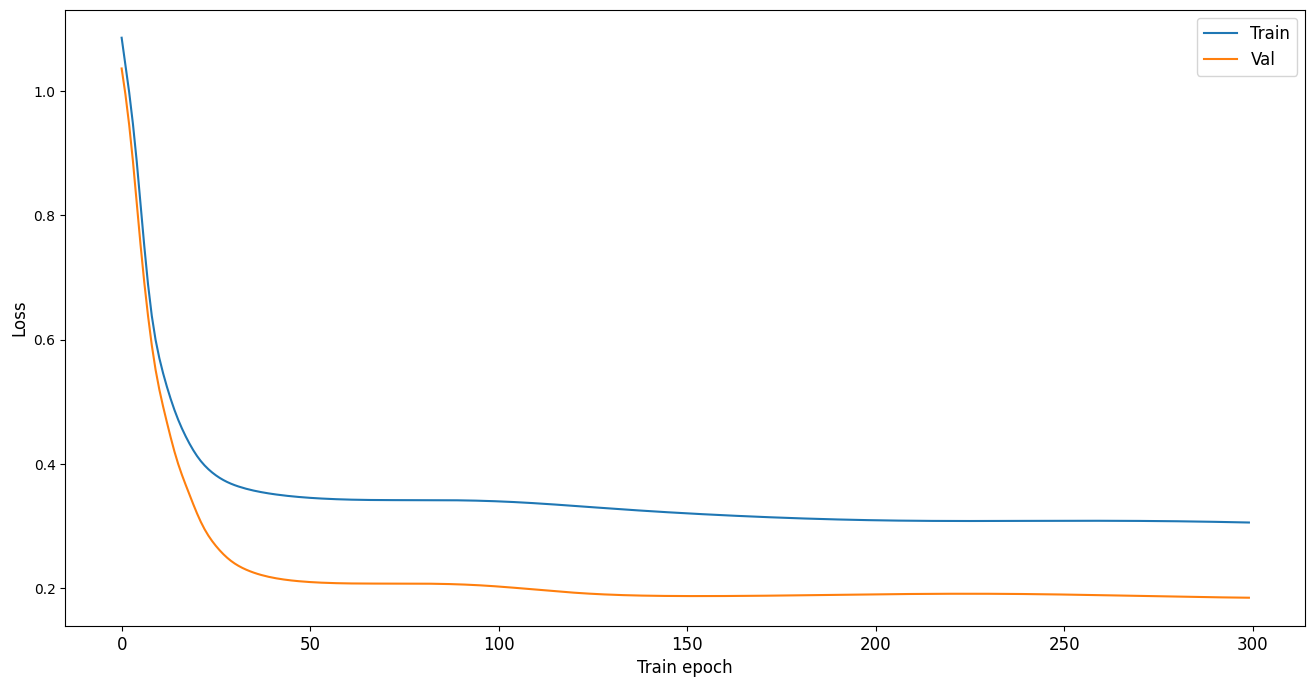

In [10]:
plot_losses(losses)

Since it is a classification problem, let's also take a look at the confusion matrix on the test set

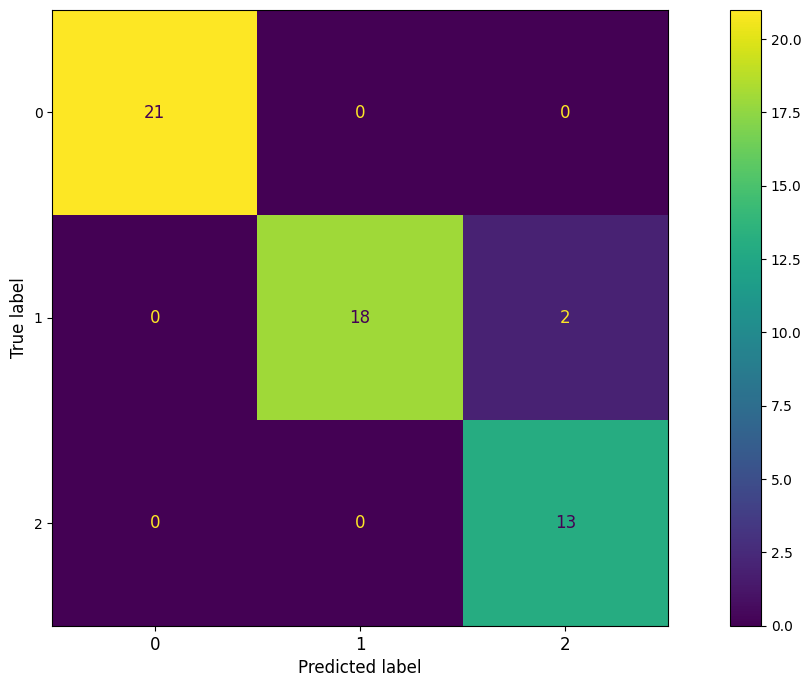

In [11]:
nn_model.eval()
pred_y_test = np.argmax(nn_model(test_data[0]).detach(), axis=1)

cm = confusion_matrix(test_data[1], pred_y_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot();

And let's compute the f1 score of the model

In [12]:
f1_score(test_data[1], pred_y_test, average="weighted")

0.9633110554163186

Let's now move to calculating influences of each point on the total score.

## Calculating influences for small neural networks

The following cell calculates the influences of each training data point on the neural network. 
Neural networks have typically a very bumpy parameter space, which, during training, is explored until the configuration that minimises the loss is found. There is an important assumption in influence functions that the model lays at a (at least local) minimum of such loss, and if this is not fulfilled many issues can arise. In order to avoid this scenario, a regularisation term should be used whenever dealing with big and noisy models. 

In [13]:
train_influences = compute_influences(
    TorchTwiceDifferentiable(nn_model, F.cross_entropy),
    training_data=training_data_loader,
    test_data=test_data_loader,
    influence_type="up",
    inversion_method="direct",
    hessian_regularization=0.1,
    progress=True,
)

Batch Split Input Gradients: 100%|██████████| 4/4 [00:00<00:00, 94.81it/s]


the returned matrix, train_influences, has a quantity of columns equal to the points in the training set, and a number of rows equal to the points in the test set. At each element $a_{i,j}$ it stores the influence that training point $j$ has on the classification of test point $i$.

If we take the average across every column of the influences matrix, we obtain an estimate of the overall influence of a training point on the total accuracy of the network.

In [14]:
mean_train_influences = np.mean(train_influences.numpy(), axis=0)

The following histogram shows that there are big differences in score within the training set (notice the log-scale on the y axis).

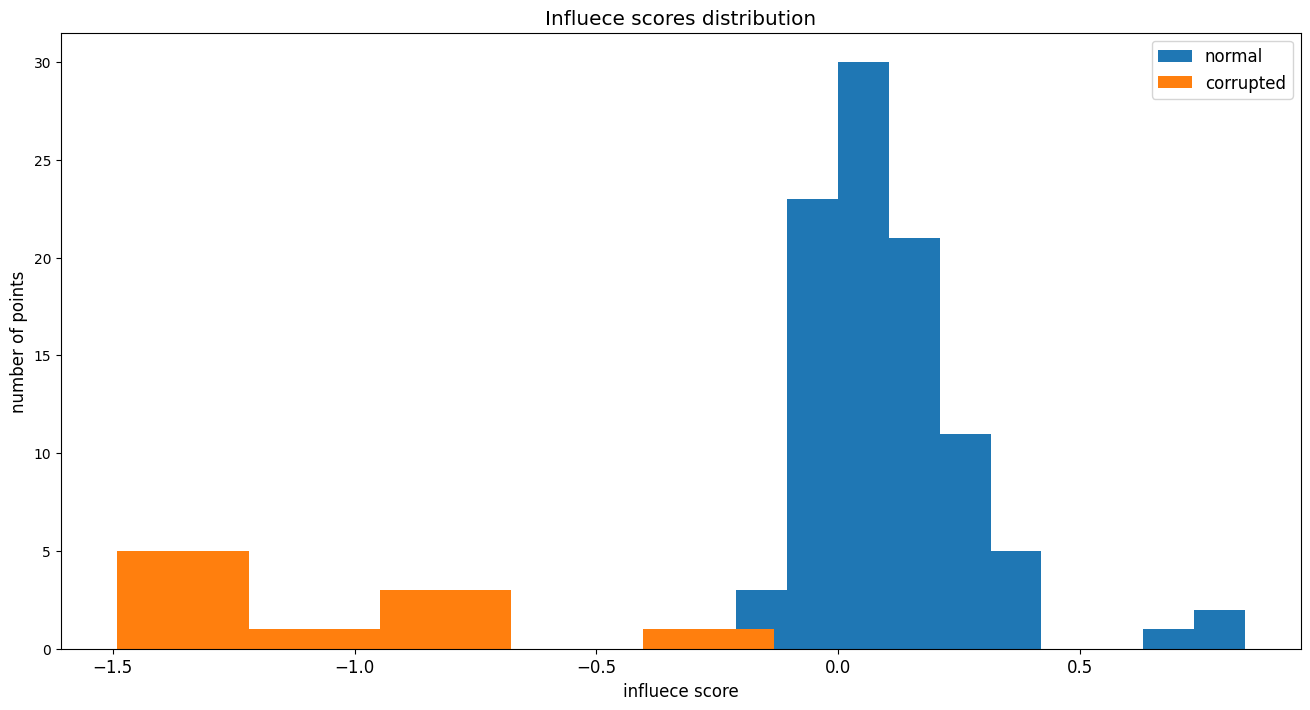

In [15]:
_, ax = plt.subplots()
ax.hist(mean_train_influences[num_corrupted_idxs:], label="normal")
ax.hist(mean_train_influences[:num_corrupted_idxs], label="corrupted", bins=5)
ax.set_title("Influece scores distribution")
ax.set_xlabel("influece score")
ax.set_ylabel("number of points")
ax.legend()
plt.show()

We can see that the corrupted points tend to have a negative effect on the model, as expected

In [16]:
print(
    "Average influence of corrupted points: ",
    np.mean(mean_train_influences[:num_corrupted_idxs]),
)
print(
    "Average influence of other points: ",
    np.mean(mean_train_influences[num_corrupted_idxs:]),
)

Average influence of corrupted points:  -1.0763495
Average influence of other points:  0.10826852


## Influence of training features

We have seen how to calculate the influence of single training points on each test point using influence_type 'up'. Using influence_type 'perturbation' we can also calculate the influence of the input features of each point. In the next cell we will calculate the average influence of each feature on training and test points, and ultimately assess which are the most relevant to model performance.

In [17]:
feature_influences = compute_influences(
    TorchTwiceDifferentiable(nn_model, F.cross_entropy),
    training_data=training_data_loader,
    test_data=test_data_loader,
    influence_type="perturbation",
    inversion_method="direct",
    hessian_regularization=1,
    progress=True,
)

Batch Influence Perturbation: 100%|██████████| 4/4 [00:02<00:00,  1.50it/s]


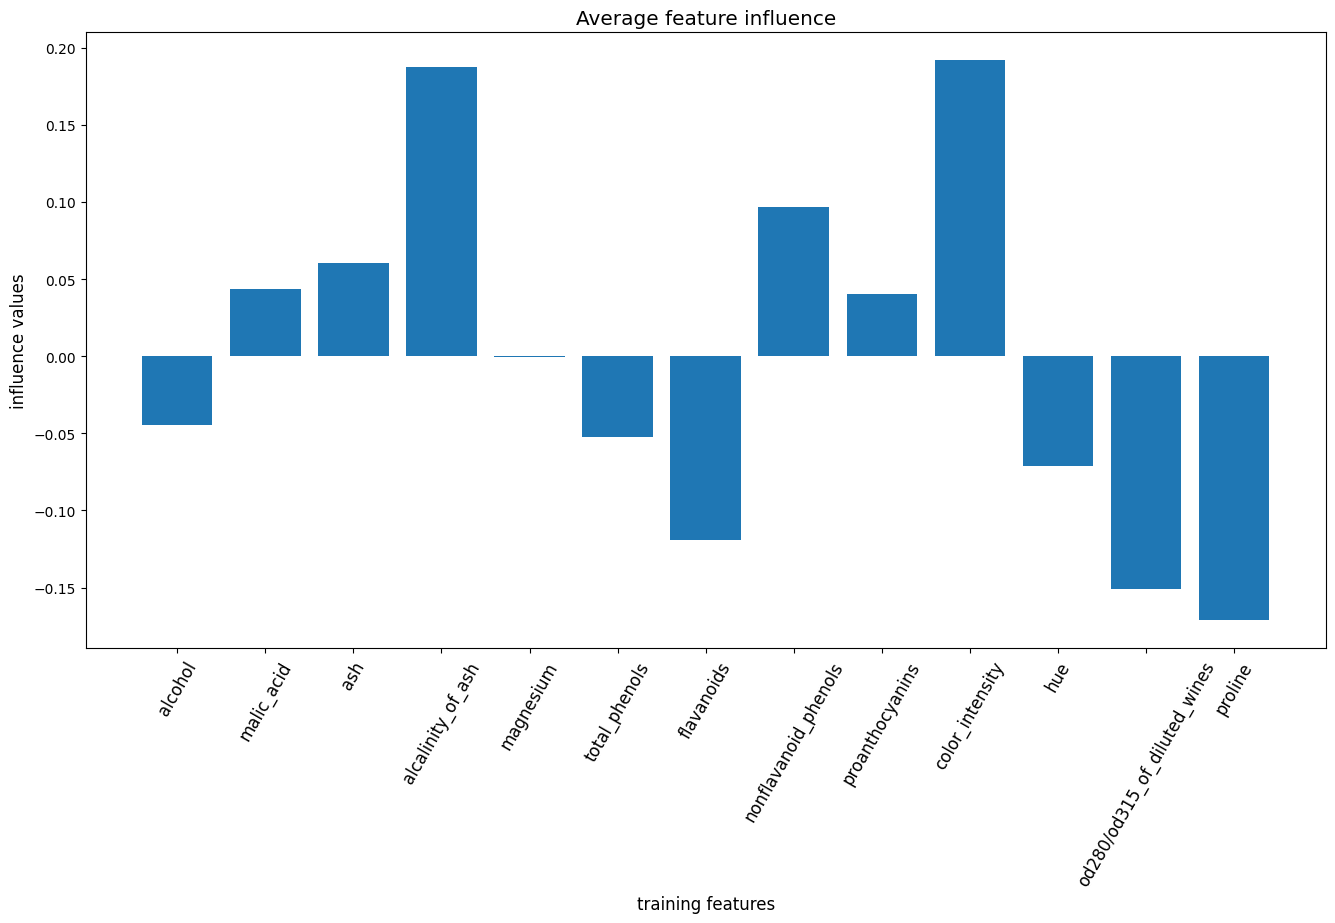

In [18]:
mean_feature_influences = np.mean(feature_influences.numpy(), axis=(0, 1))

_, ax = plt.subplots()
ax.bar(feature_names, mean_feature_influences)
ax.set_xlabel("training features")
ax.set_ylabel("influence values")
ax.set_title("Average feature influence")
plt.xticks(rotation=60)
plt.show()

## Speeding up influences for big models

The calculation of the Hessian matrix (necessary to calculate the influences) can be quite numerically challenging, both in terms of memory footprint and computation time. The full method ("direct") is fast but requires a lot of memory, and therefore can only be used for very small networks (like our current example). For bigger models, other methods are more suited.

### Conjugate Gradient

One approximate technique is called conjugate gradient ("cg"), which requires much less memory, but is also much slower. The following cell shows how to use it.

In [19]:
cg_train_influences = compute_influences(
    TorchTwiceDifferentiable(nn_model, F.cross_entropy),
    training_data=training_data_loader,
    test_data=test_data_loader,
    influence_type="up",
    inversion_method="cg",
    hessian_regularization=0.1,
    progress=True,
)
mean_cg_train_influences = np.mean(cg_train_influences.numpy(), axis=0)

Batch Split Input Gradients: 100%|██████████| 4/4 [00:00<00:00, 106.68it/s]


Let's compare the results obtained through conjugate gradient with those from the direct method

In [20]:
print(
    f"Percentage error of cg over direct method:{np.mean(np.abs(mean_cg_train_influences - mean_train_influences)/np.abs(mean_train_influences))*100} %"
)

Percentage error of cg over direct method:0.00014240363270801026 %


### Arnoldi

The Arnoldi method leverages a low rank approximation of the Hessian matrix to reduce the memory requirements. It is generally much faster than the conjugate gradient method and can achieve similar accuracy.

In [21]:
arnoldi_train_influences = compute_influences(
    TorchTwiceDifferentiable(nn_model, F.cross_entropy),
    training_data=training_data_loader,
    test_data=test_data_loader,
    influence_type="up",
    inversion_method="arnoldi",
    hessian_regularization=0.1,
    rank_estimate=30,
    progress=True,
)
mean_arnoldi_train_influences = np.mean(arnoldi_train_influences.numpy(), axis=0)

Batch Split Input Gradients: 100%|██████████| 4/4 [00:00<00:00, 65.74it/s]


In [22]:
print(
    f"Percentage error of Arnoldi over direct method:{np.mean(np.abs(mean_arnoldi_train_influences - mean_train_influences)/np.abs(mean_train_influences))*100} %"
)

Percentage error of Arnoldi over direct method:86.33190989494324 %


### EK-FAC

The EK-FAC method is a more recent technique that leverages the Kronecker product structure of the Hessian matrix to reduce the memory requirements. It is generally much faster than iterative methods like conjugate gradient and Arnoldi and it allows for an easier handling of memory. Therefore, it is the only technique that can scale to very large models (e.g. billions of parameters). Its accuracy is however much worse. Let's see how it performs on our example.

In [23]:
ekfac_train_influences = compute_influences(
    TorchTwiceDifferentiable(nn_model, F.cross_entropy),
    training_data=training_data_loader,
    test_data=test_data_loader,
    influence_type="up",
    inversion_method="ekfac",
    hessian_regularization=0.1,
    progress=True,
)
mean_ekfac_train_influences = np.mean(ekfac_train_influences.numpy(), axis=0)

Batch Split Input Gradients: 100%|██████████| 4/4 [00:00<00:00, 66.60it/s]


In [24]:
print(
    f"Percentage error of EK-FAC over direct method:{np.mean(np.abs(mean_ekfac_train_influences - mean_train_influences)/np.abs(mean_train_influences))*100} %"
)

Percentage error of EK-FAC over direct method:2442.918014526367 %


The accuracy is not good, and it is not recommended to use this method for small models. Nevertheless, a look at the actual influence values reveals that the EK-FAC estimates are not completely off.

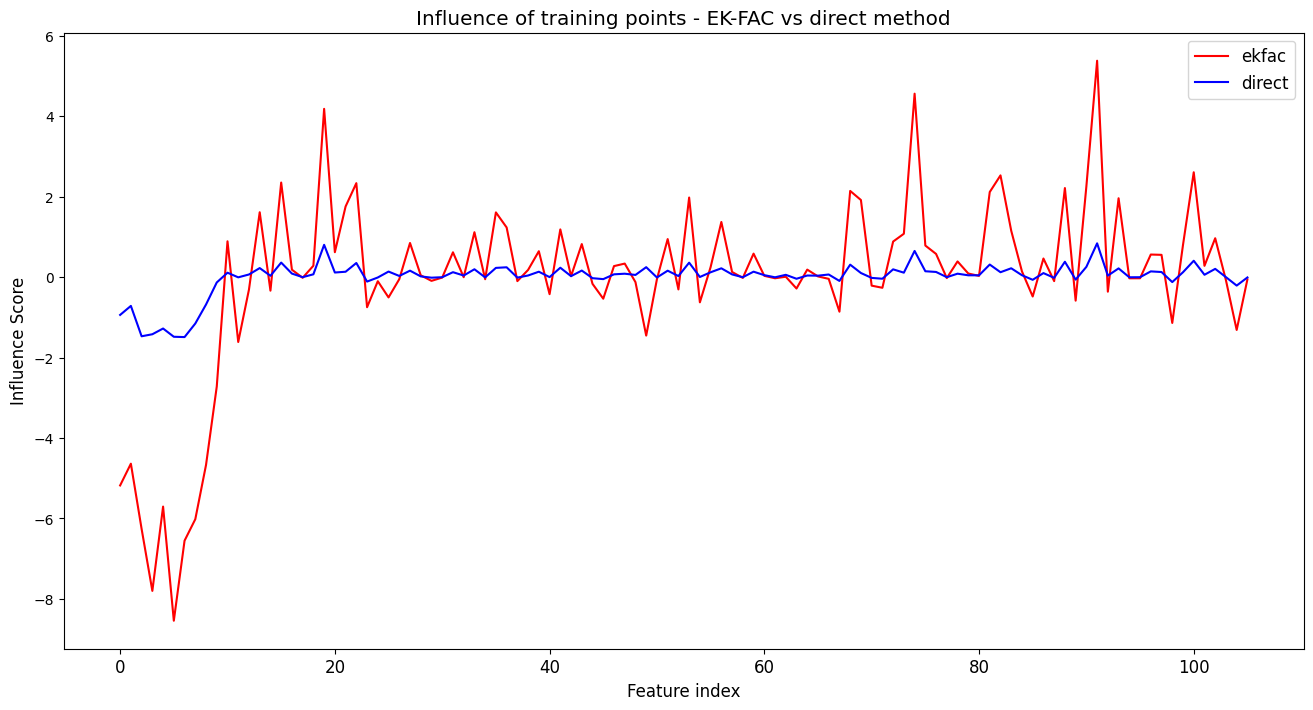

In [25]:
plt.plot(mean_ekfac_train_influences, color="red")
plt.plot(mean_train_influences, color="blue")
plt.legend(["ekfac", "direct"])
plt.xlabel("Feature index")
plt.ylabel("Influence Score")
plt.title("Influence of training points - EK-FAC vs direct method")
plt.show()

In [26]:
print(
    f"Pearson Correlation EK-FAC vs direct",
    pearsonr(mean_ekfac_train_influences, mean_train_influences).statistic,
)
print(
    f"Spearman Correlation EK-FAC vs direct",
    spearmanr(mean_ekfac_train_influences, mean_train_influences).statistic,
)

Pearson Correlation EK-FAC vs direct 0.9620622295073493
Spearman Correlation EK-FAC vs direct 0.8961735143713631


The correlation between the EK-FAC and the direct method is quite good, and it improves significantly if we just keep the points with highest absolute influence.

In [27]:
highest_inlfuence_idxs = np.argsort(np.abs(mean_train_influences))[-20:]
print(
    f"Pearson Correlation EK-FAC vs direct",
    pearsonr(
        mean_ekfac_train_influences[highest_inlfuence_idxs],
        mean_train_influences[highest_inlfuence_idxs],
    ).statistic,
)
print(
    f"Spearman Correlation EK-FAC vs direct",
    spearmanr(
        mean_ekfac_train_influences[highest_inlfuence_idxs],
        mean_train_influences[highest_inlfuence_idxs],
    ).statistic,
)

Pearson Correlation EK-FAC vs direct 0.9889900038714194
Spearman Correlation EK-FAC vs direct 0.9518796992481202


When we calculate influence scores, typically we are more interested in assessing which training points have the highest or lowest impact on the model rather than having a precise estimate of the influence value. EK-FAC then provides a fast and memory-efficient way to calculate a coarse influence ranking of the training points which scales very well even to the largest neural networks.

## Conclusions

This was a quick introduction to the pyDVL interface for influence functions. Despite their speed and simplicity, influence functions are known to be a very noisy estimator of data quality, as pointed out in the paper ["Influence functions in deep learning are fragile"](https://arxiv.org/abs/2006.14651). The size of the network, the weight decay, the inversion method used for calculating influences, the size of the test set: they all add up to the total amount of noise. Experiments may therefore give quantitative and qualitatively different results if not averaged across several realisations. Shapley values, on the contrary, have shown to be a more robust, but this comes at the cost of high computational requirements. PyDVL employs several parallelization and caching techniques to optimize such calculations.
